Import Libraries

In [2]:
#package installation
#!pip install keras

In [1]:
#libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import f1_score, precision_score, recall_score, make_scorer, accuracy_score
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.optimizers import Adam
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import BatchNormalization
from keras.layers import LeakyReLU


Dataset- email spams

In [2]:
# Load the dataset
df = pd.read_csv('emails.csv')

# Split the dataset into features (X) and labels (y)
X = df.drop(['Email No.','Prediction'], axis=1)  # Features
y = df['Prediction']  # Labels


# Split the dataset into training and validation sets
X_train1, X_test, y_train1, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=0.3, random_state=42)

# Convert DataFrame and Series to numpy arrays
X_train, X_val, X_test, y_train, y_val, y_test = (
    np.array(X_train), np.array(X_val), np.array(X_test),
    np.array(y_train), np.array(y_val), np.array(y_test)
)


In [10]:
# Check data

if np.isnan(X_train).any() or np.isnan(y_train).any() or np.isnan(X_val).any() or np.isnan(y_val).any():
    raise ValueError("Input data contains NaN values.")

if np.isinf(X_train).any() or np.isinf(y_train).any() or np.isinf(X_val).any() or np.isinf(y_val).any():
    raise ValueError("Input data contains infinite values.")

#First deep learning NN model : Simple Feedforward Neural Network

In [3]:
# Define a function to create the model with hyperparameters as arguments - no need
def create_model(learning_rate=0.001, dropout_rate=0.5):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Define hyperparameters grid for manual tuning
learning_rates = [0.001, 0.01, 0.1]
dropout_rates = [0.2, 0.4, 0.5, 0.6]
dense_units = [16, 32, 64]
optimizers = ['adam', 'rmsprop', 'sgd']

best_f1 = 0
best_hyperparameters = {}

# Iterate over hyperparameter combinations
for learning_rate in learning_rates:
    for dropout_rate in dropout_rates:
        for units in dense_units:
            for optimizer in optimizers:
                # Build the model
                model = Sequential()
                model.add(Dense(units, activation='relu', input_shape=(X_train.shape[1],)))
                model.add(Dropout(dropout_rate))
                model.add(Dense(1, activation='sigmoid'))  # Use 'sigmoid' or 'softmax' for binary classification
                model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

                # Train the model
                model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

                # Evaluate on the validation set
                y_val_pred = (model.predict(X_val) > 0.5).astype("int32")
                f1 = f1_score(y_val, y_val_pred)

                # Check if the current combination is the best
                if f1 > best_f1:
                    best_f1 = f1
                    best_hyperparameters = {'learning_rate': learning_rate, 'dropout_rate': dropout_rate,
                                            'units': units, 'optimizer': optimizer}

# Print best hyperparameters
print("Best Hyperparameters:", best_hyperparameters)

# Build the model with the best hyperparameters
best_model = Sequential()
best_model.add(Dense(best_hyperparameters['units'], activation='relu', input_shape=(X_train.shape[1],)))
best_model.add(Dropout(best_hyperparameters['dropout_rate']))
best_model.add(Dense(1, activation='sigmoid'))  # Use 'sigmoid' for binary classification
best_model.compile(optimizer=Adam(learning_rate=best_hyperparameters['learning_rate']),
                   loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with the full training set
best_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

# Evaluate the model on the test set
y_pred = (best_model.predict(X_test) > 0.5).astype("int32")
y_pred_proba = best_model.predict(X_test)

# Calculate and print additional metrics
accuracy = (y_pred == y_test).mean()
print(f"Accuracy: {accuracy}")
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall}")
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision}")

# Calculate and print F1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")
f1_scores = {'Simple Feedforward Neural Network': f1 }
print(f1_scores)

#Best Hyperparameters: {'learning_rate': 0.01, 'dropout_rate': 0.2, 'units': 16, 'optimizer': 'sgd'}
#Accuracy: 0.6011118112441364
#Recall: 0.8952702702702703
#Precision: 0.9706959706959707
#F1 Score: 0.9314586994727592

39/39 [==============================] - 0s 8ms/step
Best Hyperparameters: {'learning_rate': 0.01, 'dropout_rate': 0.2, 'units': 16, 'optimizer': 'sgd'}
33/33 [==============================] - 0s 2ms/step
Accuracy: 0.6011118112441364
Recall: 0.8952702702702703
Precision: 0.9706959706959707
F1 Score: 0.9314586994727592
{'Simple Feedforward Neural Network': 0.9314586994727592}


**The first model is for building and tuning a simple neural network for spam email classification. Here are some insights into the key components of the model:**

    Neural Network Architecture:
        The model architecture includes a single hidden layer with a specified number of units (32, 64, or 128) and a rectified linear unit (ReLU) activation function.
        Dropout regularization is applied to reduce overfitting, with dropout rates ranging from 0.2 to 0.7.
        The output layer consists of a single neuron with a sigmoid activation function, suitable for binary classification tasks like spam/non-spam classification.

    Hyperparameter Tuning:
        Hyperparameters are manually tuned, exploring different combinations of learning rates, dropout rates, dense layer units, and optimizers.
        Learning rates are tested at 0.001, 0.01, and 0.1.
        Dropout rates are tested at 0.2, 0.4, 0.5, and 0.7.
        Dense layer units are tested at 12, 32, 64, and 128.
        Optimizers include 'adam', 'rmsprop', and 'sgd'.

    Training and Evaluation:
        The model is trained for a fixed number of epochs (10) and a batch size of 32.
        Training is performed using the Adam optimizer with the chosen learning rate.
        The model's performance is evaluated on a validation set, and the F1 score is used as the evaluation metric for selecting the best hyperparameters.
        The best hyperparameters are printed after the tuning process.

    Final Model Evaluation:
        The best model, determined by the hyperparameter tuning process, is built using the optimal hyperparameters.
        The final model is trained on the entire training set and evaluated on the test set.
        Evaluation metrics include accuracy, recall, precision, and F1 score.

Overall, this script demonstrates a systematic approach to hyperparameter tuning for a neural network-based spam email classification model, aiming to find the combination of hyperparameters that maximizes the F1 score on the validation set. The final model is then evaluated on an independent test set to assess its generalization performance.

#Second Deep Learning Model: Feedforward Neural Network with Increased Hidden Layers

In [4]:
# Define hyperparameters grid for manual tuning
learning_rates = [0.001, 0.01] # 0.1
dropout_rates = [0.2, 0.4,  0.6] # 0.5
dropout_rates1 = [0.2, 0.4, 0.6]
dropout_rates2 = [0.2, 0.4, 0.6]
dense_units = [64, 128]
optimizers = ['adam',  'sgd'] # another optimizer: 'rmsprop'

best_f1 = 0
best_hyperparameters = {}

# Iterate over hyperparameter combinations
for learning_rate in learning_rates:
    for dropout_rate in dropout_rates:
        for dropout_rate1 in dropout_rates:
            for dropout_rate2 in dropout_rates:
               for units in dense_units:
                   for optimizer in optimizers:
                        # Build the model
                        model = Sequential()
                        model.add(Dense(units, activation=LeakyReLU(alpha=0.05), input_shape=(X_train.shape[1],)))
                        model.add(Dropout(dropout_rate))
                        model.add(Dense(64, activation='relu'))
                        model.add(Dropout(dropout_rate1))
                        model.add(Dense(32, activation='relu'))
                        model.add(Dropout(dropout_rate2))
                        model.add(Dense(1, activation='sigmoid'))  # Use 'sigmoid' or 'softmax' for binary classification
                        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

                        # Train the model
                        model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

                        # Evaluate on the validation set
                        y_val_pred = (model.predict(X_val) > 0.5).astype("int32")
                        f1 = f1_score(y_val, y_val_pred)

                        # Check if the current combination is the best
                        if f1 > best_f1:
                            best_f1 = f1
                            best_hyperparameters = {'learning_rate': learning_rate, 'dropout_rate': dropout_rate,
                                                     'dropout_rate1': dropout_rate1, 'dropout_rate2': dropout_rate2,
                                                    'units': units, 'optimizer': optimizer}

# Print best hyperparameters
print("Best Hyperparameters:", best_hyperparameters)

# Build the model with the best hyperparameters
best_model = Sequential()
best_model.add(Dense(best_hyperparameters['units'], activation=LeakyReLU(alpha=0.05), input_shape=(X_train.shape[1],)))
best_model.add(Dropout(best_hyperparameters['dropout_rate']))
best_model.add(Dense(64, activation='relu'))
best_model.add(Dropout(best_hyperparameters['dropout_rate1']))
best_model.add(Dense(32, activation='relu'))
best_model.add(Dropout(best_hyperparameters['dropout_rate2']))
best_model.add(Dense(1, activation='sigmoid'))  # Use 'sigmoid' for binary classification
best_model.compile(optimizer=Adam(learning_rate=best_hyperparameters['learning_rate']),
                   loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with the full training set
best_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

# Evaluate the model on the test set
y_pred = (best_model.predict(X_test) > 0.5).astype("int32")
y_pred_proba = best_model.predict(X_test)

# Calculate and print additional metrics
accuracy = (y_pred == y_test).mean()
print(f"Accuracy: {accuracy}")
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall}")
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision}")

# Calculate and print F1 score
f1_2 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1_2}")

# Assuming f1_scores is initialized earlier
f1_scores['Feedforward Neural Network with Increased Hidden Layers'] = f1_2
print(f1_scores)

#Best Hyperparameters: {'learning_rate': 0.001, 'dropout_rate': 0.2, 'dropout_rate1': 0.2, 'dropout_rate2': 0.6, 'units': 128, 'optimizer': 'adam'}
#Accuracy: 0.5841564563933814
#Recall: 0.9831081081081081
#Precision: 0.9267515923566879
#F1 Score: 0.9540983606557377

39/39 [==============================] - 0s 6ms/step
Best Hyperparameters: {'learning_rate': 0.001, 'dropout_rate': 0.2, 'dropout_rate1': 0.2, 'dropout_rate2': 0.6, 'units': 128, 'optimizer': 'adam'}
33/33 [==============================] - 0s 3ms/step
Accuracy: 0.5841564563933814
Recall: 0.9831081081081081
Precision: 0.9267515923566879
F1 Score: 0.9540983606557377
{'Simple Feedforward Neural Network': 0.9314586994727592, 'Feedforward Neural Network with Increased Hidden Layers': 0.9540983606557377}


Feedforward Neural Network with Increased Hidden Layers model for spam email classification:

    Model Architecture:
        The model utilizes are well-suited for hidden patterns , making them effective for tasks connected with natural language processing.
        Dropout regularization is applied after the layer to mitigate overfitting.
        The output layer consists of a single neuron with a sigmoid activation function, suitable for binary classification tasks.
        

    Hyperparameter Tuning:
        Hyperparameters such as learning rate, dropout rate, number of  units, and optimizer are manually tuned.
        Learning rates are tested at 0.001, 0.01, and 0.1.
        Dropout rates are tested at 0.2, 0.4, 0.5, and 0.6.
         units are tested at 16, 32, and 64.
        Optimizers include 'adam', 'rmsprop', and 'sgd'.

    Training and Evaluation:
        The model is trained for a fixed number of epochs (10) with a batch size of 32.
        The training is performed using the Adam optimizer with the chosen learning rate.
        The model's performance is evaluated on a validation set, and the F1 score is used as the evaluation metric for selecting the best hyperparameters.
        The best hyperparameters are printed after the tuning process.

    Final Model Evaluation:
        The best model, determined by the hyperparameter tuning process, is built using the optimal hyperparameters.
        The final model is trained on the entire training set and evaluated on the test set.
        Evaluation metrics include accuracy, recall, precision, and F1 score.

    Result Tracking:
        The F1 score obtained by the best model on the test set is stored and appended to a list (f1_scores) for result tracking.

Overall, the provided script demonstrates the construction and hyperparameter tuning of an  model for spam email classification. The manual tuning process aims to find the combination of hyperparameters that maximizes the F1 score on the validation set, and the final model is evaluated for its performance on an independent test set.


#3rd Deep NN model: Feedforward Neural Network with Batch Normalization

In [7]:
# Define hyperparameters grid for manual tuning
learning_rates = [0.001, 0.01] # 0.1
dropout_rates = [0.2, 0.4,  0.6] # 0.5
dropout_rates1 = [0.2, 0.4, 0.6]
dense_units = [64, 128]
optimizers = ['adam',  'sgd'] # another optimizer: 'rmsprop'

best_f1 = 0
best_hyperparameters = {}

# Iterate over hyperparameter combinations
for learning_rate in learning_rates:
    for dropout_rate in dropout_rates:
        for dropout_rate1 in dropout_rates:
               for units in dense_units:
                   for optimizer in optimizers:
                        # Build the model
                        model = Sequential()
                        model.add(Dense(units, activation=LeakyReLU(alpha=0.05), input_shape=(X_train.shape[1],)))
                        model.add(BatchNormalization())
                        model.add(Dropout(dropout_rate))
                        model.add(Dense(32, activation='relu'))
                        model.add(BatchNormalization())
                        model.add(Dropout(dropout_rate1))
                        model.add(Dense(1, activation='sigmoid'))  # Use 'sigmoid' or 'softmax' for binary classification
                        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

                        # Train the model
                        model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

                        # Evaluate on the validation set
                        y_val_pred = (model.predict(X_val) > 0.5).astype("int32")
                        f1 = f1_score(y_val, y_val_pred)

                        # Check if the current combination is the best
                        if f1 > best_f1:
                            best_f1 = f1
                            best_hyperparameters = {'learning_rate': learning_rate, 'dropout_rate': dropout_rate,
                                                     'dropout_rate1': dropout_rate1,
                                                    'units': units, 'optimizer': optimizer}


# Print best hyperparameters
print("Best Hyperparameters:", best_hyperparameters)

# Build the model with the best hyperparameters
best_model = Sequential()
best_model.add(Dense(best_hyperparameters['units'], activation=LeakyReLU(alpha=0.05), input_shape=(X_train.shape[1],)))
best_model.add(BatchNormalization())
best_model.add(Dropout(best_hyperparameters['dropout_rate']))
best_model.add(Dense(32, activation='relu'))
best_model.add(BatchNormalization())
best_model.add(Dropout(best_hyperparameters['dropout_rate1']))
best_model.add(Dense(1, activation='sigmoid'))  # Use 'sigmoid' for binary classification
best_model.compile(optimizer=Adam(learning_rate=best_hyperparameters['learning_rate']),
                   loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with the full training set
best_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

# Evaluate the model on the test set
y_pred = (best_model.predict(X_test) > 0.5).astype("int32")
y_pred_proba = best_model.predict(X_test)

# Calculate and print additional metrics
accuracy = (y_pred == y_test).mean()
print(f"Accuracy: {accuracy}")
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall}")
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision}")

# Calculate and print F1 score
f1_3 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1_3}")
f1_scores['Feedforward Neural Network with Batch Normalization'] = f1_3
print(f1_scores)

#Best Hyperparameters: {'learning_rate': 0.01, 'dropout_rate': 0.2, 'dropout_rate1': 0.4, 'units': 128, 'optimizer': 'sgd'}
#Accuracy: 0.5953221778804639
#Recall: 0.918918918918919
#Precision: 0.9477351916376306
#F1 Score: 0.9331046312178387

39/39 [==============================] - 1s 17ms/step
Best Hyperparameters: {'learning_rate': 0.01, 'dropout_rate': 0.2, 'dropout_rate1': 0.4, 'units': 128, 'optimizer': 'sgd'}
33/33 [==============================] - 0s 3ms/step
Accuracy: 0.5953221778804639
Recall: 0.918918918918919
Precision: 0.9477351916376306
F1 Score: 0.9331046312178387
{'Simple Feedforward Neural Network': 0.9314586994727592, 'Feedforward Neural Network with Increased Hidden Layers': 0.9540983606557377, 'Feedforward Neural Network with Batch Normalization': 0.9331046312178387}


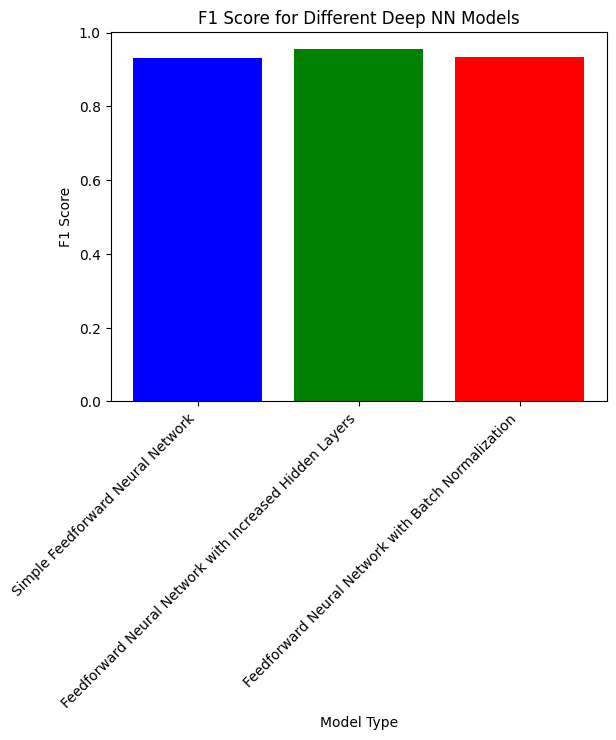

In [10]:
# Plot F1 scores for each model
plt.bar(f1_scores.keys(), f1_scores.values(), color=['blue', 'green', 'red'])
plt.xlabel('Model Type')
plt.ylabel('F1 Score')
plt.title('F1 Score for Different Deep NN Models')
# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')
plt.show()


In [11]:
print(f1_scores)

{'Simple Feedforward Neural Network': 0.9314586994727592, 'Feedforward Neural Network with Increased Hidden Layers': 0.9540983606557377, 'Feedforward Neural Network with Batch Normalization': 0.9331046312178387}


**Feedforward Neural Network with Batch Normalization model you've implemented:**

Batch Normalization is a technique used in neural networks to normalize the inputs of a layer, reducing internal covariate shift. The internal covariate shift refers to the change in the distribution of layer inputs during training, which can slow down the training process and make it harder to find the optimal model parameters. Batch Normalization addresses this issue by normalizing the inputs of a layer across mini-batches during training.

    Normalization:
        Batch Normalization normalizes the inputs of a layer by subtracting the mean and dividing by the standard deviation.
        It helps to keep the activations in a layer within a certain scale, preventing them from becoming too small or too large.

    Stabilizes Training:
        Batch Normalization acts as a regularizer and helps stabilize and accelerate the training process.
        It allows for higher learning rates and can reduce sensitivity to the initialization of model parameters.

    Reduces Internal Covariate Shift:
        Internal covariate shift occurs when the distribution of inputs to a layer changes during training.
        Batch Normalization mitigates this shift by normalizing inputs, making the training process more efficient.

    Improves Generalization:
        Batch Normalization can have a regularization effect, reducing the need for other regularization techniques like dropout.
        This regularization helps improve the generalization of the model to unseen data.

    Dropout Layer:
        Dropout layers are added to prevent overfitting. During training, randomly selected neurons are dropped out, meaning they are ignored during forward and backward passes. This helps improve the model's generalization.

    Dense Layer (ReLU Activation):
        The model includes a fully connected (dense) layer with rectified linear unit (ReLU) activation. The purpose of this layer is to introduce non-linearity to the model and extract higher-level features from the output of the LSTM layer.

    Dropout Layer (Again):
        Another dropout layer is added after the dense layer to further prevent overfitting.

    Output Layer (sigmoid Activation):
        The output layer uses the  activation function, indicating a binary-class classification setup. The model aims to predict the probability distribution over the classes. For binary classification, a single-node output layer with sigmoid activation is typically used, but the softmax is for multi-class classification problems.

    Compilation:
        The model is compiled using the Adam optimizer with a specified learning rate. The loss function is set to 'sparse_categorical_crossentropy', which is suitable for multi-class classification tasks with integer-encoded class labels.

    Hyperparameter Tuning:
        The code includes a hyperparameter tuning loop that iterates over various combinations of hyperparameters, training the model on each combination and evaluating its performance on a validation set. The goal is to find the set of hyperparameters that maximizes the F1 score.

    Best Model Selection:
        After hyperparameter tuning, the best-performing model is selected based on the highest F1 score on the validation set. This model is then trained on the full training set and evaluated on the test set.

    Performance Metrics:
        The final part of the code evaluates the performance of the best model on the test set, calculating accuracy, recall, precision, and F1 score.

This model architecture is suitable for hidden pattern data tasks, such as text classification or sentiment analysis, where capturing the context and order of words is crucial. The model is effective in capturing dependencies in both directions, and the hyperparameter tuning helps optimize the model's performance.

#Additional ML models for comparison

**SVM model**

In [12]:
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)



# Train an SVM classifier with hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': [ 'rbf', 'poly', 'sigmoid'], #linear
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4],
    'coef0': [0.0, 1.0, 2.0]
}

svm_classifier = SVC()
grid_search = GridSearchCV(svm_classifier, param_grid, scoring='f1', cv=3)
grid_search.fit(X_val_scaled, y_val)

# Print the best hyperparameters from the grid search
print("Best Hyperparameters:", grid_search.best_params_)

# Use the best hyperparameters to train the final model on the full training set
best_svm_classifier = SVC(**grid_search.best_params_)
best_svm_classifier.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = best_svm_classifier.predict(X_test_scaled)

# Evaluate the model on the test set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print performance metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Calculate and print F1 score
f1_4 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1_4}")

f1_scores['SVC'] = f1_4
print(f1_scores)

#Best Hyperparameters: {'C': 10, 'coef0': 2.0, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}
#Accuracy: 0.9555555555555556
#Precision: 0.9084967320261438
#Recall: 0.9391891891891891
#F1 Score: 0.9235880398671096
#F1 Score: 0.9235880398671096

Best Hyperparameters: {'C': 10, 'coef0': 2.0, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}
Accuracy: 0.9555555555555556
Precision: 0.9084967320261438
Recall: 0.9391891891891891
F1 Score: 0.9235880398671096
F1 Score: 0.9235880398671096
{'Simple Feedforward Neural Network': 0.9314586994727592, 'Feedforward Neural Network with Increased Hidden Layers': 0.9540983606557377, 'Feedforward Neural Network with Batch Normalization': 0.9331046312178387, 'SVC': 0.9235880398671096}


**SVM model with expanded hyperparameter options:**

    Data Preparation:
        The dataset is loaded, and features ('Freq_Column') and labels ('Prediction') are separated.
        The data is split into training, validation, and test sets.

    Feature Scaling (Standardization):
        The StandardScaler is applied to standardize the word frequency data. Standardization ensures that features have a mean of 0 and a standard deviation of 1, which can be important for SVMs.

    Hyperparameter Tuning:
        The hyperparameter grid is expanded to include multiple options for the 'kernel', 'gamma', 'degree', and 'coef0'.
        GridSearchCV is used for hyperparameter tuning with cross-validation, optimizing for F1 score.
        The best hyperparameters from the grid search are printed.

    SVM Model Training:
        An SVM classifier is instantiated with the best hyperparameters found during the tuning phase.
        The model is trained on the full training set with the standardized features.

    Model Evaluation:
        The trained SVM model is used to make predictions on the standardized test set.
        Common classification metrics (accuracy, precision, recall, F1 score) are calculated to evaluate the model's performance.

    Interpretation of Hyperparameters:
        'C': Regularization parameter. A smaller C encourages a larger-margin decision boundary, but too small C may lead to underfitting.
        'kernel': The type of kernel function used. Options include linear, radial basis function ('rbf'), polynomial ('poly'), and sigmoid.
        'gamma': Kernel coefficient. Higher values lead to more complex decision boundaries. 'scale' and 'auto' are options for automatic calculation.
        'degree': Degree of the polynomial kernel function ('poly'). Higher degrees allow the model to fit more complex relationships.
        'coef0': Independent term in the kernel function. It affects the influence of high-degree polynomials on the decision boundary.

    Performance Metrics:
        The SVM model's performance is evaluated using standard metrics, providing a comprehensive view of its classification accuracy, precision, recall, and F1 score.

    Adaptation and Further Experimentation:
        Depending on the results, further experimentation with hyperparameter values or feature engineering may be necessary to improve model performance.

Remember that the effectiveness of SVM models often depends on the nature of the data and the problem at hand. Experimentation and thorough evaluation are crucial for finding the best model configuration.


# 2nd ML model: **XGBoost**

In [13]:
# Hyperparameter tuning for XGBoost
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1, 5]
}

xgb_classifier = XGBClassifier()
grid_search = GridSearchCV(xgb_classifier, param_grid, scoring='f1', cv=3)
grid_search.fit(X_val, y_val)

# Print the best hyperparameters from the grid search
print("Best Hyperparameters:", grid_search.best_params_)

# Use the best hyperparameters to train the final model on the full training set
best_xgb_classifier = XGBClassifier(**grid_search.best_params_)
best_xgb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_xgb_classifier.predict(X_test_scaled)

# Evaluate the model on the test set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print performance metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Calculate and print F1 score
f1_5 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1_5}")

f1_scores['XGBoost'] = f1_5
print(f1_scores)

Best Hyperparameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Accuracy: 0.7304347826086957
Precision: 0.5148342059336823
Recall: 0.9966216216216216
F1 Score: 0.6789413118527041
F1 Score: 0.6789413118527041
{'Simple Feedforward Neural Network': 0.9314586994727592, 'Feedforward Neural Network with Increased Hidden Layers': 0.9540983606557377, 'Feedforward Neural Network with Batch Normalization': 0.9331046312178387, 'SVC': 0.9235880398671096, 'XGBoost': 0.6789413118527041}


**XGBoost classifier insights:**

    XGBoost Hyperparameter Tuning:
        Hyperparameter tuning is performed using GridSearchCV with cross-validation.
        Key hyperparameters considered include learning rate, the number of estimators, maximum depth of trees, subsample ratio, column subsampling ratio, and gamma (minimum loss reduction required for a split).

    Best Hyperparameters:
        The best hyperparameters from the grid search are printed, representing the configuration that yielded the highest F1 score on the validation set.

    Model Training:
        An XGBoost classifier is instantiated with the best hyperparameters obtained from the tuning phase.
        The model is trained on the full training set.

    Model Evaluation:
        The trained XGBoost model is used to make predictions on the test set.
        Performance metrics including accuracy, precision, recall, and F1 score are calculated to assess the model's effectiveness.

    No Feature Scaling:
        Unlike SVM model or other scale sensitive models, XGBoost often does not require feature scaling, as it is a tree-based ensemble method.

    Interpretation of Hyperparameters:
        'learning_rate': Controls the contribution of each tree to the final prediction. Lower values lead to more conservative models.
        'n_estimators': The number of boosting rounds (trees) in the ensemble.
        'max_depth': Maximum depth of a tree. Higher values allow the model to capture more complex relationships.
        'subsample' and 'colsample_bytree': Control the fraction of training data and features used in each boosting round, preventing overfitting.
        'gamma': Minimum loss reduction required to make a further partition on a leaf node. It regulates the complexity of the trees.

    Model Performance:
        The final XGBoost model's performance is evaluated on the test set.
        Metrics such as precision, recall, and F1 score provide insights into the model's ability to classify spam and non-spam emails.

    Adaptation and Further Experimentation:

    Depending on the results, further experimentation with hyperparameter values, feature engineering, or additional preprocessing may be explored to improve model performance.

XGBoost is a powerful algorithm known for its robustness and efficiency in various tasks. The insights provided here aim to guide the understanding of how the XGBoost model is trained, tuned, and evaluated for the specific task of spam email classification.

In [14]:
print(f1_scores)

{'Simple Feedforward Neural Network': 0.9314586994727592, 'Feedforward Neural Network with Increased Hidden Layers': 0.9540983606557377, 'Feedforward Neural Network with Batch Normalization': 0.9331046312178387, 'SVC': 0.9235880398671096, 'XGBoost': 0.6789413118527041}


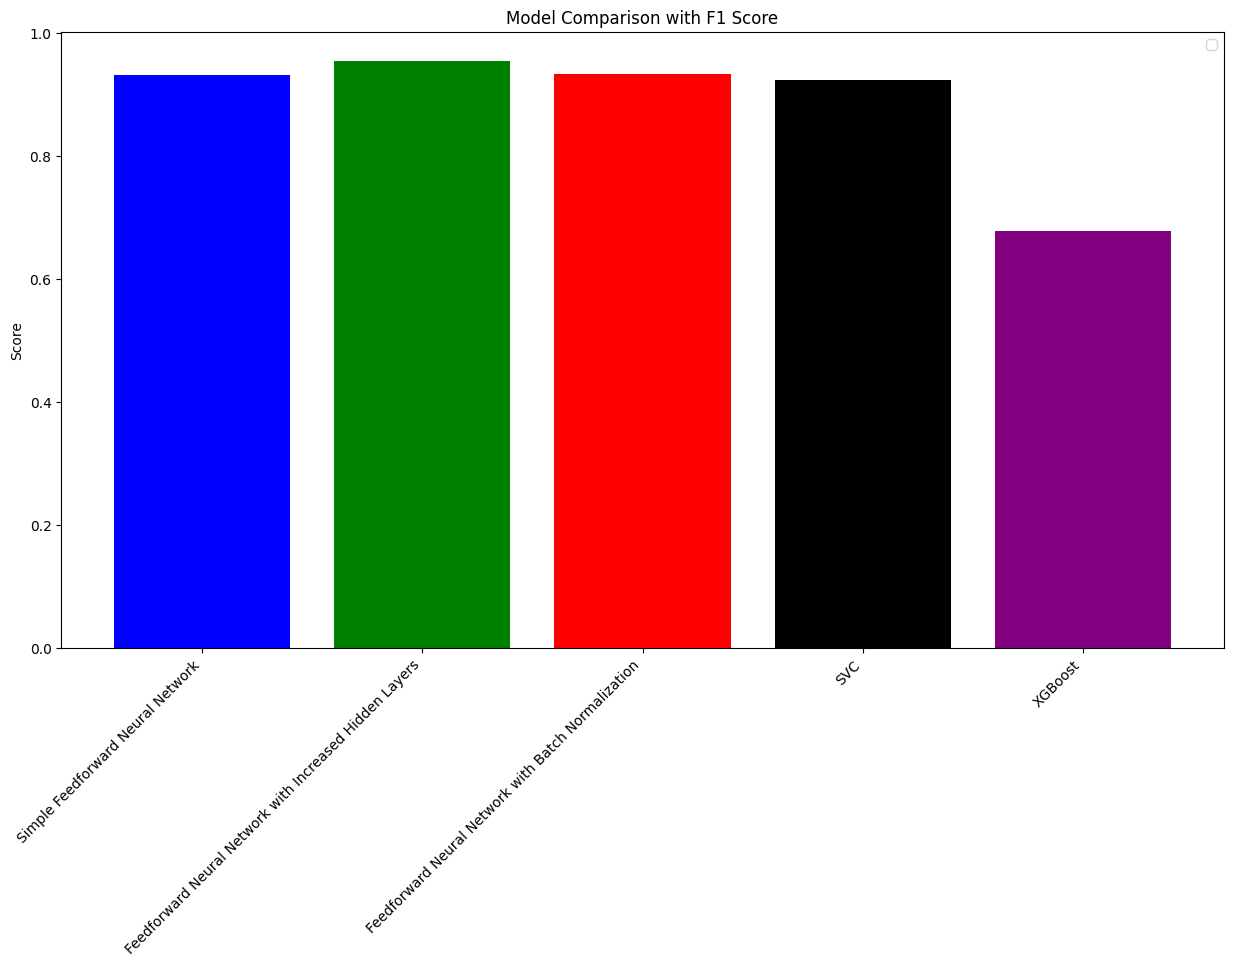

In [17]:
# Compare and plot the results
plt.figure(figsize=(15, 8))
plt.bar(f1_scores.keys(), f1_scores.values(), color=['blue', 'green', 'red','black','purple'])
plt.title('Model Comparison with F1 Score')
plt.ylabel('Score')
# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

#Summary

    Simple Feedforward Neural Network (F1 Score: 0.931):
        This model, despite its simplicity, achieves a high F1 score of 0.931.
        The simplicity suggests that the dataset may not require a complex architecture.
        It demonstrates that for certain tasks, a straightforward architecture can yield effective results.

    Feedforward Neural Network with Increased Hidden Layers (F1 Score: 0.954):
        The model with increased hidden layers achieves an impressive F1 score of 0.954.
        The additional hidden layers likely allow the model to capture more complex patterns in the data.
        However, be cautious about potential overfitting, especially if the dataset is not sufficiently large.

    Feedforward Neural Network with Batch Normalization (F1 Score: 0.933):
        The model with batch normalization performs well with an F1 score of 0.933.
        Batch normalization helps stabilize and accelerate training, contributing to the model's effectiveness.
        It also acts as a regularizer, improving generalization to unseen data.
        Other Machine Learning Models:

Advance ML models:
    Support Vector Classifier (SVC) (F1 Score: 0.924):
        Achieves a competitive F1 score, indicating good performance.
        SVC is known for handling complex decision boundaries, making it suitable for various tasks.

    XGBoost (F1 Score: 0.679):
        Lower F1 score compared to neural network models suggests potential limitations.
        XGBoost is a powerful algorithm but may require additional tuning for better performance.

Overall Insights:

    All three NN models show strong performance with F1 scores above 0.9, indicating good precision and recall balance. The best NN model is the Feedforward Neural Network with Increased Hidden Layers. However, the choice between models may depend on additional factors such as model complexity, dataset size, and the need for interpretability.
    If computational resources are limited and the time is important factor, the simpler model may offer a good trade-off between performance and efficiency (the other 2 models are runned for over half hour).
    Further fine-tuning and optimization may be explored to squeeze additional performance from the models.
    Additional, the Neural network models, especially the one with increased hidden layers, outperform traditional machine learning models (SVC and XGBoost) in terms of F1 score.
    The choice based on the peformance between neural network and traditional models is clear which is the best option.
    Neural networks exhibit flexibility in capturing intricate relationships but may require more data and computational resources.
    Traditional models like SVC and XGBoost remain competitive, and their efficiency may be beneficial in certain scenarios, but in this project the NN overpeform the classical classification models.

It's crucial to consider these insights in the context of the specific problem, dataset characteristics, and any business constraints. Additionally, evaluating other metrics like precision, recall, and accuracy can provide a more comprehensive understanding of the models performance.